# [MOTrainer: Measurement Operator Trainer](https://zenodo.org/record/7540443)

An example notebook that reads data and convert it to xarray Dataset with aligned time and space axis.

## Import libraries and set paths

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt # only for plots
from pathlib import Path

In [2]:
data_dir = "./dssat_s1/data/"
nc_file_path = "./dssat_s1/data/example_data.nc"

## Read the data and explore it

In [3]:
pickle_files_path = list(Path(data_dir).rglob('*.pkl'))
pickle_files_path

[PosixPath('dssat_s1/data/Sentinel-1/Amp_CR_New.pkl'),
 PosixPath('dssat_s1/data/DSSAT/brabant_SWTD6.pkl'),
 PosixPath('dssat_s1/data/DSSAT/brabant_LAI.pkl'),
 PosixPath('dssat_s1/data/DSSAT/brabant_SWTD.pkl'),
 PosixPath('dssat_s1/data/DSSAT/brabant_CWAD.pkl')]

In [4]:
for file in pickle_files_path:
    df = pd.read_pickle(file)  # read file as pandas dataframe
    print(file.stem)  # check file name
    print(df.index.dtype)  # check index type
    print(len(df.index))  # check length of index
    print(len(df.columns))  # check length of columns
    print("********")

Amp_CR_New
object
60
21927
********
brabant_SWTD6
datetime64[ns]
274
1283
********
brabant_LAI
datetime64[ns]
148
1283
********
brabant_SWTD
datetime64[ns]
274
1283
********
brabant_CWAD
datetime64[ns]
148
1283
********


## Convert data

As seen above, the type of index of data are not consitent among different files e.g. "object" and "datetime64[ns]". Below, we convert it to the same type.


In [5]:
# Read the data
ds_list = []
for file in pickle_files_path:
    # read files and extract filename
    df = pd.read_pickle(file)
    var_name = file.stem

    # Check the dtype of the index. If it's not datetime64[ns], convert it.
    if df.index.dtype != "datetime64[ns]":
        df.index = pd.to_datetime(df.index)

    # convert dataframe to dataset
    ds = xr.Dataset({var_name: (["time", "location"], df.values)},
                     coords={"time": df.index, "location": df.columns})
    ds_list.append(ds)

# Create one dataset
dataset = xr.concat(ds_list, dim="time")

# Add attribute (metadata)
dataset.attrs['source'] = 'data source'
dataset.attrs['license'] = 'data license'

## Inspect output and store it

In [6]:
dataset

<xarray.Dataset>
Dimensions:        (location: 21927, time: 904)
Coordinates:
  * location       (location) int64 1526157 1526199 1526200 ... 2311808 2311820
  * time           (time) datetime64[ns] 2017-01-01 2017-01-07 ... 2017-09-30
Data variables:
    Amp_CR_New     (time, location) float64 0.1435 0.2744 0.1326 ... nan nan nan
    brabant_SWTD6  (time, location) float64 nan nan nan nan ... nan nan nan nan
    brabant_LAI    (time, location) float64 nan nan nan nan ... nan nan nan nan
    brabant_SWTD   (time, location) float64 nan nan nan nan ... nan nan nan nan
    brabant_CWAD   (time, location) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    source:   data source
    license:  data license

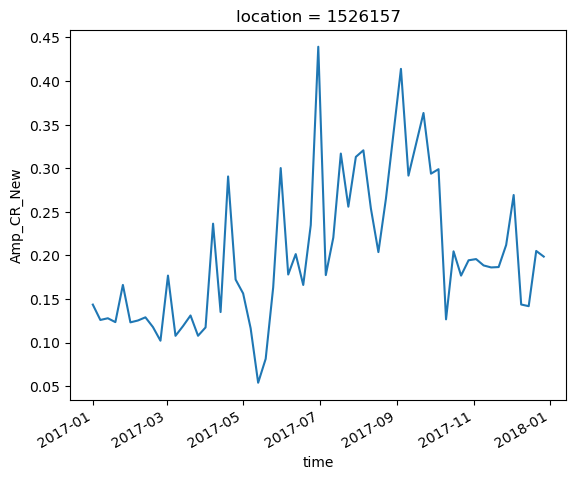

In [7]:
# Time series of one variable at one location
Amp_CR_New = dataset.Amp_CR_New.isel(location=0)
Amp_CR_New.plot()

In [8]:
# Save data in netcdf format
dataset.to_netcdf(nc_file_path)